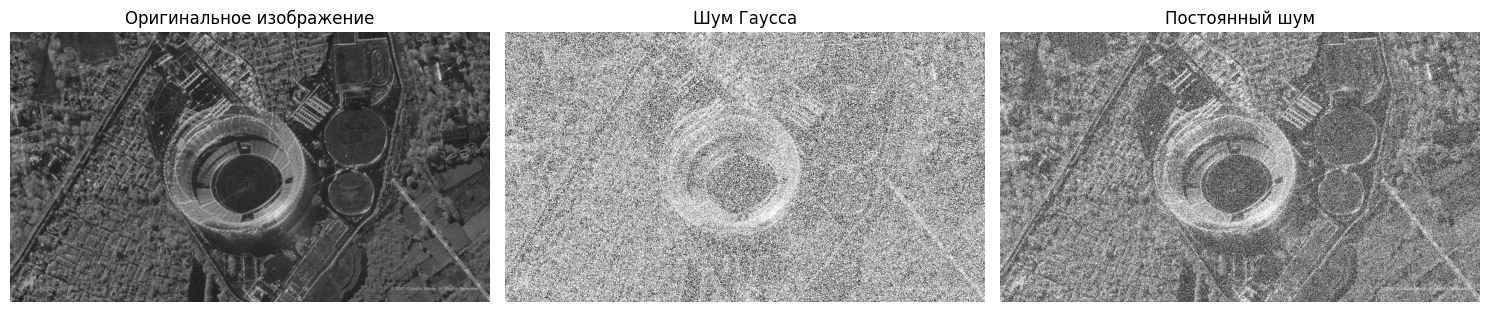

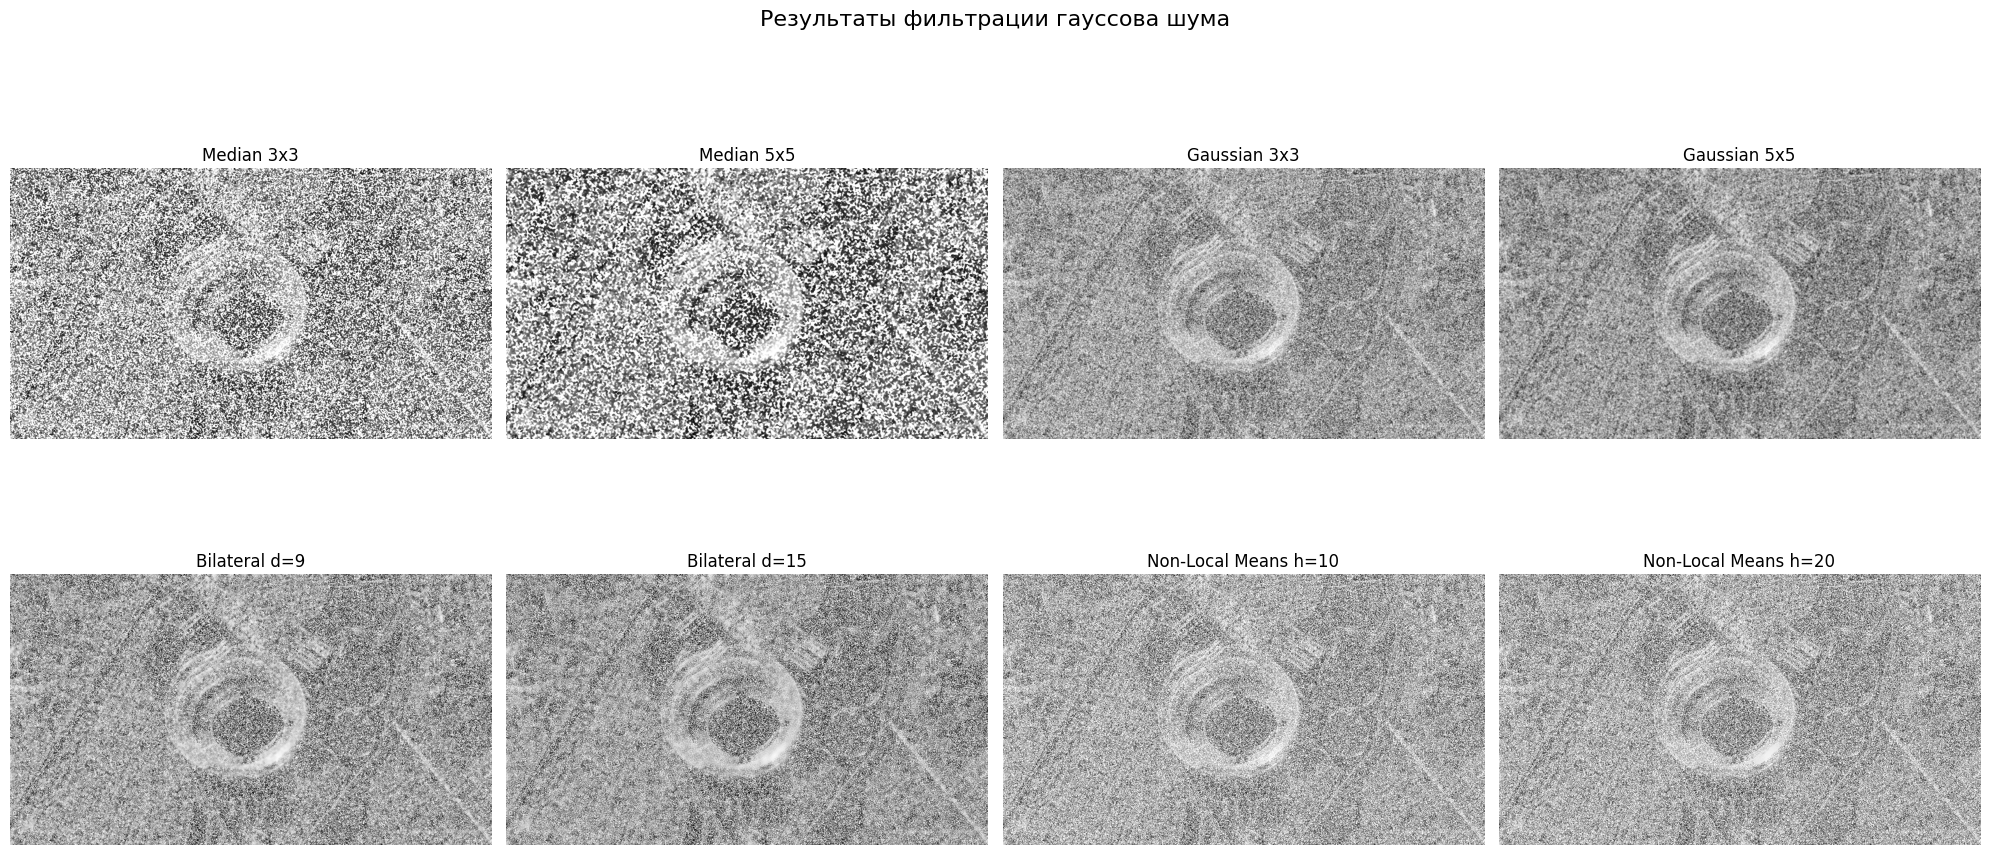

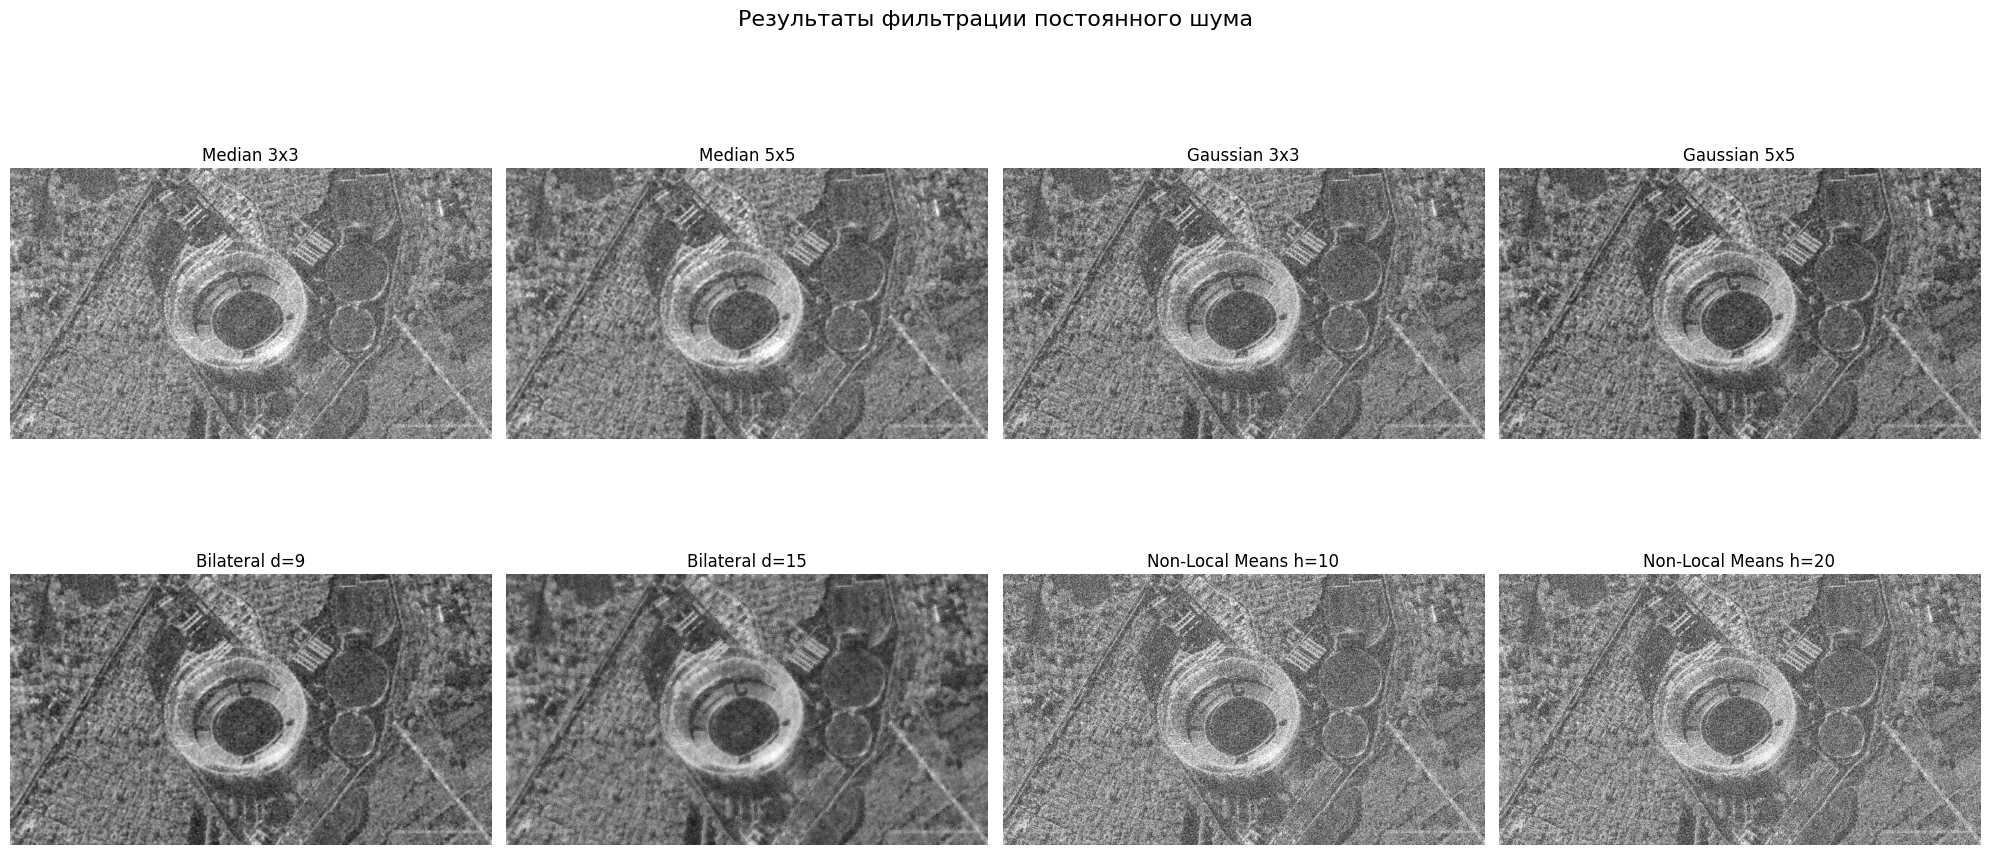

Результаты фильтрации (MSE, SSIM, PSNR):

Шум Гаусса:
Фильтр			MSE		SSIM		PSNR
Median 3x3          	15606.44		0.0530		27.56
Median 5x5          	15257.55		0.0535		27.54
Gaussian 3x3        	10272.78		0.1729		27.85
Gaussian 5x5        	9874.35		0.2115		27.85
Bilateral d=9       	13746.09		0.0692		27.62
Bilateral d=15      	13706.67		0.0658		27.61
Non-Local Means h=10	15835.47		0.0547		28.10
Non-Local Means h=20	15834.26		0.0549		28.10

Постоянный шум:
Фильтр			MSE		SSIM		PSNR
Median 3x3          	3578.27		0.3479		27.57
Median 5x5          	3350.18		0.3749		27.54
Gaussian 3x3        	3393.57		0.4131		27.53
Gaussian 5x5        	3253.11		0.4575		27.53
Bilateral d=9       	3515.22		0.3376		27.55
Bilateral d=15      	3521.05		0.3086		27.55
Non-Local Means h=10	5721.30		0.1713		27.88
Non-Local Means h=20	5720.09		0.1715		27.88

Лучший фильтр для шума Гаусса: Non-Local Means h=10
Лучший фильтр для постоянного шума: Non-Local Means h=10


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, mean_squared_error

def load_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

def add_constant_noise(image, a=110, b=0):
    mid = (a + b) / 2
    stdev = a - mid
    
    noise_constant = np.zeros(image.shape, np.float32)
    cv2.randn(noise_constant, mid, stdev)
    
    noisy_image = image.astype(np.float32) + noise_constant
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def apply_filters(noisy_images):
    filters = {
        'Median 3x3': {
            'gn': cv2.medianBlur(noisy_images['gn'], 3),
            'constant': cv2.medianBlur(noisy_images['constant'], 3)
        },
        'Median 5x5': {
            'gn': cv2.medianBlur(noisy_images['gn'], 5),
            'constant': cv2.medianBlur(noisy_images['constant'], 5)
        },
        'Gaussian 3x3': {
            'gn': cv2.GaussianBlur(noisy_images['gn'], (3, 3), 0),
            'constant': cv2.GaussianBlur(noisy_images['constant'], (3, 3), 0)
        },
        'Gaussian 5x5': {
            'gn': cv2.GaussianBlur(noisy_images['gn'], (5, 5), 0),
            'constant': cv2.GaussianBlur(noisy_images['constant'], (5, 5), 0)
        },
        'Bilateral d=9': {
            'gn': cv2.bilateralFilter(noisy_images['gn'], 9, 75, 75),
            'constant': cv2.bilateralFilter(noisy_images['constant'], 9, 75, 75)
        },
        'Bilateral d=15': {
            'gn': cv2.bilateralFilter(noisy_images['gn'], 15, 75, 75),
            'constant': cv2.bilateralFilter(noisy_images['constant'], 15, 75, 75)
        },
        'Non-Local Means h=10': {
            'gn': cv2.fastNlMeansDenoising(noisy_images['gn'], None, 10, 7, 21),
            'constant': cv2.fastNlMeansDenoising(noisy_images['constant'], None, 10, 7, 21)
        },
        'Non-Local Means h=20': {
            'gn': cv2.fastNlMeansDenoising(noisy_images['gn'], None, 20, 7, 21),
            'constant': cv2.fastNlMeansDenoising(noisy_images['constant'], None, 20, 7, 21)
        }
    }
    return filters

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_metrics(original, filtered):
    mse = mean_squared_error(original, filtered)
    ssim_val = ssim(original, filtered)
    psnr_val = calculate_psnr(original, filtered)
    return mse, ssim_val, psnr_val

def evaluate_filters(original, filters):
    results = {}
    for filter_name, filtered_imgs in filters.items():
        results[filter_name] = {
            'Gaussian': calculate_metrics(original, filtered_imgs['gn']),
            'Constant': calculate_metrics(original, filtered_imgs['constant'])
        }
    return results

def plot_original_and_noisy(original, noisy_gn, noisy_constant):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Оригинальное изображение')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_gn, cmap='gray')
    plt.title('Шум Гаусса')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(noisy_constant, cmap='gray')
    plt.title('Постоянный шум')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_filtered_results(filters, noise_type, title):
    plt.figure(figsize=(20, 10))
    plt.suptitle(title, fontsize=16)
    
    for i, (filter_name, filtered_imgs) in enumerate(filters.items()):
        plt.subplot(2, 4, i + 1)
        plt.imshow(filtered_imgs[noise_type], cmap='gray')
        plt.title(filter_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def print_results(results):
    print("Результаты фильтрации (MSE, SSIM, PSNR):")
    print("\nШум Гаусса:")
    print("Фильтр\t\t\tMSE\t\tSSIM\t\tPSNR")
    for filter_name, metrics in results.items():
        mse, ssim_val, psnr_val = metrics['Gaussian']
        print(f"{filter_name:20}\t{mse:.2f}\t\t{ssim_val:.4f}\t\t{psnr_val:.2f}")

    print("\nПостоянный шум:")
    print("Фильтр\t\t\tMSE\t\tSSIM\t\tPSNR")
    for filter_name, metrics in results.items():
        mse, ssim_val, psnr_val = metrics['Constant']
        print(f"{filter_name:20}\t{mse:.2f}\t\t{ssim_val:.4f}\t\t{psnr_val:.2f}")

def find_best_filters(results):
    best_gn_filter = max(results, key=lambda k: results[k]['Gaussian'][2])
    best_constant_filter = max(results, key=lambda k: results[k]['Constant'][2])
    
    print(f"\nЛучший фильтр для шума Гаусса: {best_gn_filter}")
    print(f"Лучший фильтр для постоянного шума: {best_constant_filter}")
    
    return best_gn_filter, best_constant_filter

def main():
    img = load_image('sar_1.jpg')
    
    img_gn = add_gaussian_noise(img)
    img_constant = add_constant_noise(img)
    
    plot_original_and_noisy(img, img_gn, img_constant)
    
    noisy_images = {'gn': img_gn, 'constant': img_constant}
    filters = apply_filters(noisy_images)
    
    results = evaluate_filters(img, filters)
    
    plot_filtered_results(filters, 'gn', 'Результаты фильтрации гауссова шума')
    plot_filtered_results(filters, 'constant', 'Результаты фильтрации постоянного шума')
    
    print_results(results)
    best_gn_filter, best_constant_filter = find_best_filters(results)

if __name__ == "__main__":
    main()
